

---

### **Q1**

---



Recording: [Maman13Q1 recording](https://drive.google.com/file/d/1UytsoEc5IofOZLpE4koPZzff_-vBdTh7/view?usp=sharing)

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn


In [6]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


In [7]:
# device object
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

device

device(type='cpu')



---
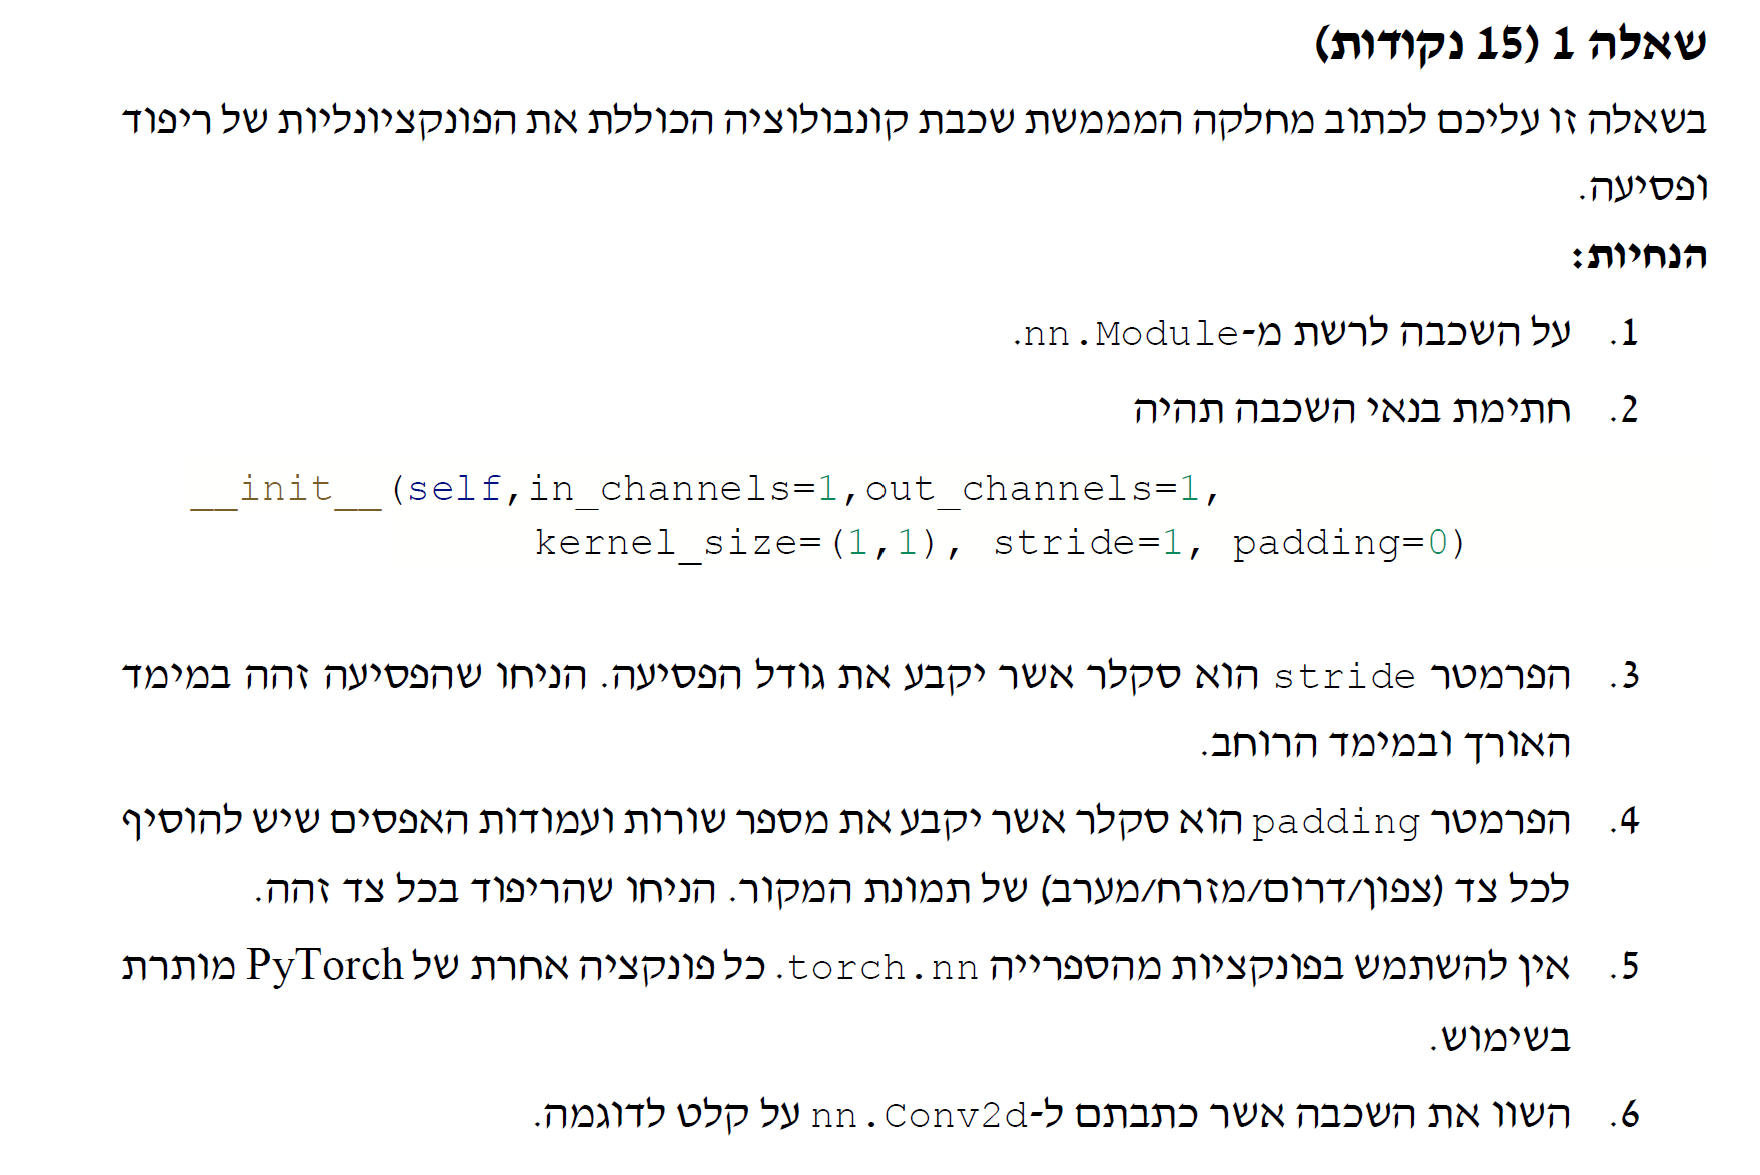


---



In [8]:
class My_ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, kernel_size=(1,1), stride=1, padding_size=0):
        super().__init__()
        self.kernel = nn.Parameter(
            torch.rand((out_channels,in_channels,*kernel_size)))
        self.bias = nn.Parameter(torch.rand((out_channels,1)))

        self.p , self.q  = kernel_size
        self.padding_size = padding_size
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    @staticmethod
    def padding(img, padding_size):
      print("Image shape before resize: ", img.shape)
      sizes = list(img.shape)
      sizes[-1] = sizes[-1] + 2*padding_size
      sizes[-2] = sizes[-2] + 2*padding_size
      padded_img = torch.zeros(sizes)
      padded_img[:,:,padding_size: img.shape[-2] + padding_size, padding_size: img.shape[-2] + padding_size] = \
      padded_img[:,:,padding_size: img.shape[-1] + padding_size, padding_size: img.shape[-1] + padding_size] + img

      print("Image shape after resize: ", padded_img.shape)
      return padded_img

    def forward(self, X):
        X = self.padding(X, self.padding_size)

        new_hight = int((X.size(2) - self.p) / self.stride) + 1
        new_width = int((X.size(3) - self.q) / self.stride) + 1
        
        output = torch.empty(X.size(0),
                            self.out_channels,
                            new_hight,
                            new_width)
        rows = output.size(2)
        cols = output.size(3)
        for i in range(0, rows):
            ix = i*self.stride
            for j in range(0, cols):
                jx = j*self.stride
                sub_img = X[:,:,ix:(ix+self.p),jx:(jx+self.q)]
                sub_img=sub_img.unsqueeze(1)
                output[:,:,i,j]=(sub_img*self.kernel).sum(dim=(2,3,4))

        return output+ self.bias.reshape(1,-1,1,1)



---


## **Padding - sanity check**

---



Check that no padding (padding_size = 0) is supported

In [ ]:
A = torch.arange(1,10).reshape(3,3)

In [ ]:
print("My_ConvLayer.padding", A, My_ConvLayer.padding(A.unsqueeze(0).unsqueeze(0), 0), sep='\n')

Image shape before resize:  torch.Size([1, 1, 3, 3])
Image shape after resize:  torch.Size([1, 1, 3, 3])
My_ConvLayer.padding
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])


**Padding = 1**

In [ ]:
print("My_ConvLayer.padding", A, My_ConvLayer.padding(A.unsqueeze(0).unsqueeze(0), 1), sep='\n')

Image shape before resize:  torch.Size([1, 1, 3, 3])
Image shape after resize:  torch.Size([1, 1, 5, 5])
My_ConvLayer.padding
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[[[0., 0., 0., 0., 0.],
          [0., 1., 2., 3., 0.],
          [0., 4., 5., 6., 0.],
          [0., 7., 8., 9., 0.],
          [0., 0., 0., 0., 0.]]]])


**Padding = 3**

In [ ]:
print("My_ConvLayer.padding", A, My_ConvLayer.padding(A.unsqueeze(0).unsqueeze(0), 3), sep='\n')

Image shape before resize:  torch.Size([1, 1, 3, 3])
Image shape after resize:  torch.Size([1, 1, 9, 9])
My_ConvLayer.padding
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 2., 3., 0., 0., 0.],
          [0., 0., 0., 4., 5., 6., 0., 0., 0.],
          [0., 0., 0., 7., 8., 9., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])




---



---


# **Testing on Fashion MNIST**

---



In [ ]:
train_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=1)
img, _ = next(iter(train_dataloader))



---



---


# **Edge Detector**

---



In [ ]:
filter = torch.tensor([[-1.,-1,-1],[0,0,0],[1,1,1]]).reshape(1,1,3,3)
filter.requires_grad = True


In [ ]:
conv_layer = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=2,padding=3)

with torch.no_grad():
    conv_layer.weight = nn.Parameter(filter)

img2 = conv_layer(img)
print(img2.shape)

torch.Size([1, 1, 16, 16])


In [ ]:
my=My_ConvLayer(in_channels=1,out_channels=1,kernel_size=(3,3),stride=2, padding_size=3)
my.bias = torch.nn.Parameter(conv_layer._parameters['bias'], requires_grad=False)

my.kernel.requires_grad=False
my.kernel[:]=filter
img3=my(img)
print(img3.size())

Image shape before resize:  torch.Size([1, 1, 28, 28])
Image shape after resize:  torch.Size([1, 1, 34, 34])
torch.Size([1, 1, 16, 16])


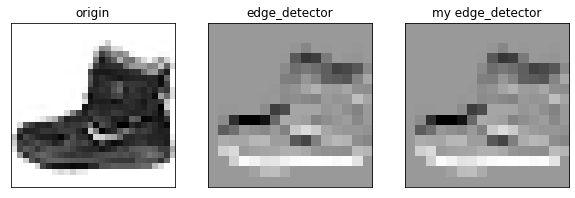

In [ ]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(10)
axes[0].imshow(img.squeeze().detach(),cmap='Greys')
axes[0].set_title("origin")
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)


axes[1].imshow(img2.detach().squeeze().detach(),cmap='Greys')
axes[1].set_title("edge_detector")
axes[1].axes.get_xaxis().set_visible(False)
axes[1].axes.get_yaxis().set_visible(False)

axes[2].imshow(img3.detach().squeeze().detach(),cmap='Greys')
axes[2].set_title("my edge_detector")
axes[2].axes.get_xaxis().set_visible(False)
axes[2].axes.get_yaxis().set_visible(False)

Make sure that My_ConvLayer and Conv2D Produce the same output

In [ ]:
diff = (abs(img3 - img2))

epsilon = 1e-7
(diff < epsilon).all()

tensor(False)

In [ ]:
epsilon = 1e-6
(diff < epsilon).all()

tensor(True)

In [ ]:
print(diff)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9605e-08, 2.3842e-07,
           1.1921e-07, 2.9802e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.000



---



---


## **Stride**

---



In [ ]:
A1=torch.arange(25,dtype=torch.float).reshape(1,1,5,5)
kernel1 = torch.tensor(1.).reshape(1,1,1,1)

In [ ]:
downsample = nn.Conv2d(in_channels=1, out_channels=1,
                        kernel_size=(1, 1),
                       stride=2)
downsample.weight=nn.Parameter(kernel1)
print(A1,downsample(A1),sep='\n')

tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]])
tensor([[[[ 0.4285,  2.4285,  4.4285],
          [10.4285, 12.4285, 14.4285],
          [20.4285, 22.4285, 24.4285]]]], grad_fn=<ConvolutionBackward0>)


In [ ]:
my_downsample = My_ConvLayer(in_channels=1, out_channels=1,kernel_size=(1, 1),
                       stride=2)
my_downsample.bias = torch.nn.Parameter(downsample._parameters['bias'], requires_grad=False)
my_downsample.kernel=nn.Parameter(kernel1)

print(A1,my_downsample(A1),sep='\n')

Image shape before resize:  torch.Size([1, 1, 5, 5])
Image shape after resize:  torch.Size([1, 1, 5, 5])
tensor([[[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]])
tensor([[[[ 0.4285,  2.4285,  4.4285],
          [10.4285, 12.4285, 14.4285],
          [20.4285, 22.4285, 24.4285]]]], grad_fn=<AddBackward0>)
